In [2]:
import numpy as np # linear algebra
from numpy import newaxis
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

print ('import completed')

import completed


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Enrol_window = 60

print ('enrol window set to',Enrol_window )

enrol window set to 60


In [5]:
sc = MinMaxScaler(feature_range=(0,1))
def load_data(datasetname, column, seq_len, normalise_window):
    # A support function to help prepare datasets for an RNN/LSTM/GRU
    data = datasetname.loc[:,column]

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        #result = sc.fit_transform(result)
        result = normalise_windows(result)

    result = np.array(result)

    #Last 10% is used for validation test, first 90% for training
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    # A support function to normalize a dataset
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of <prediction_len> steps before shifting prediction run forward by <prediction_len> steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs


def plot_results(predicted_data, true_data, model): 
    fig = plt.figure(facecolor='white', figsize = (15,8)) 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='Real Evolution')
    if model == "GRU": 
      ax.set_title("Testing Model GRU SMI")
    else:
      ax.set_title("Testing Model LSTM SMI")
    plt.plot(predicted_data, label='Forecast') 
    plt.legend() 
    plt.show() 
    
def plot_results_multiple(predicted_data, true_data, prediction_len, model):
    fig = plt.figure(facecolor='white', figsize = (15,8))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='Observed Evolution')
    if model == "GRU": 
      ax.set_title("Forecast GRU SMI")
    else:
      ax.set_title("Forecast LSTM SMI")
 
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Forecast')
        plt.legend(loc = "lower right", fontsize = 9)
    plt.show()

print ('Support functions defined')

Support functions defined


In [6]:
dataset = pd.read_csv('/content/drive/My Drive/SMI.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Close,Open,High,Low,Vol.,Change %
Date,,,,,,
2012-02-01,6070,"5,984.11","6,077.40","5,979.22",55.10M,1.67%
2012-02-02,6064,"6,083.36","6,085.11","6,038.53",51.60M,-0.09%
2012-02-03,6153,"6,062.44","6,158.11","6,046.99",55.58M,1.47%
2012-02-06,6147,"6,126.54","6,150.80","6,103.77",40.33M,-0.10%
2012-02-07,6158,"6,143.40","6,158.50","6,114.68",51.76M,0.17%


In [ ]:
feature_train, label_train, feature_test, label_test = load_data(dataset, 'Close', Enrol_window, True)

In [8]:
# The same LSTM model I would like to test, lets see if the sinus prediction results can be matched
# Note: replace LSTM with GRU or RNN if you want to try those

model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')

print ('model compiled')

model compiled


In [9]:
b = model.fit(feature_train, label_train, batch_size=128, epochs=50, validation_data = (feature_test, label_test))

Epoch 1/50
14/14 [==============================] - 17s 1s/step - loss: 9.0790e-04 - val_loss: 1.7124e-04
Epoch 2/50
14/14 [==============================] - 15s 1s/step - loss: 4.2887e-04 - val_loss: 1.5806e-04
Epoch 3/50
14/14 [==============================] - 16s 1s/step - loss: 3.5820e-04 - val_loss: 1.4397e-04
Epoch 4/50
14/14 [==============================] - 16s 1s/step - loss: 3.2642e-04 - val_loss: 1.3628e-04
Epoch 5/50
14/14 [==============================] - 16s 1s/step - loss: 2.9439e-04 - val_loss: 1.7202e-04
Epoch 6/50
14/14 [==============================] - 16s 1s/step - loss: 2.8876e-04 - val_loss: 1.2792e-04
Epoch 7/50
14/14 [==============================] - 16s 1s/step - loss: 2.5590e-04 - val_loss: 1.3298e-04
Epoch 8/50
14/14 [==============================] - 16s 1s/step - loss: 2.5133e-04 - val_loss: 1.1913e-04
Epoch 9/50
14/14 [==============================] - 16s 1s/step - loss: 2.3804e-04 - val_loss: 1.2330e-04
Epoch 10/50
14/14 [===========================

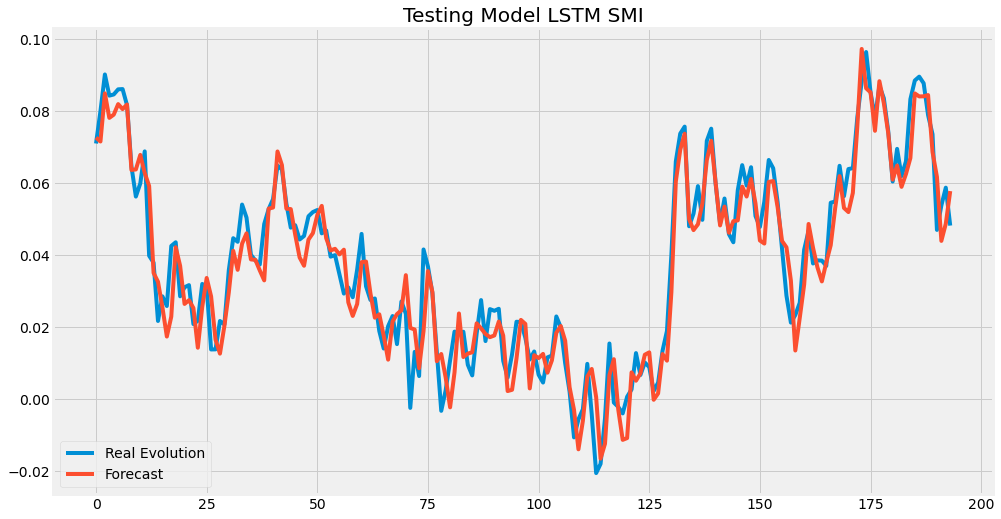

In [10]:
predicted_stock_price = model.predict(feature_test)
plot_results(predicted_stock_price,label_test, model = "LSTM")

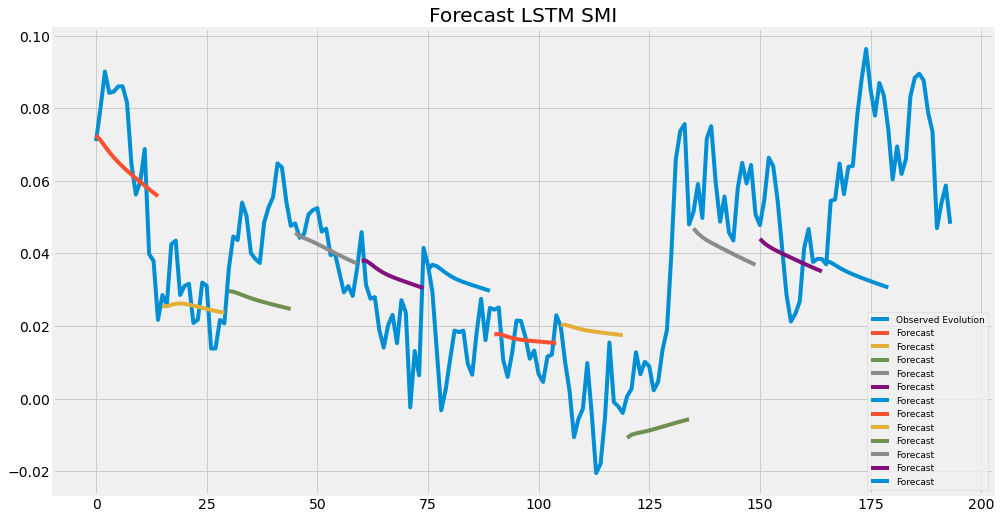

In [11]:
predictions = predict_sequences_multiple(model, feature_test, Enrol_window, 15)
plot_results_multiple(predictions, label_test, 15, model = "LSTM")  

In [12]:
import math
from sklearn.metrics import mean_squared_error
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [13]:
return_rmse(predicted_stock_price,label_test)

The root mean squared error is 0.007211204370815115.


In [14]:
modelGRU = Sequential()
modelGRU.add(GRU(60, return_sequences=True, input_shape=(feature_train.shape[1],1),activation='tanh'))
modelGRU.add(Dropout(0.2))
modelGRU.add(GRU(60, return_sequences=True,activation='tanh'))
modelGRU.add(Dropout(0.2))
modelGRU.add(GRU(units=60, return_sequences=False,activation='tanh'))
modelGRU.add(Dropout(0.2))
modelGRU.add(Dense(1, activation = "linear"))

modelGRU.compile(loss='mse', optimizer='adam')

print ('model compiled')


model compiled


In [15]:
c = modelGRU.fit(feature_train, label_train, batch_size=128, epochs=50, validation_data = (feature_test, label_test))

Epoch 1/50
14/14 [==============================] - 3s 241ms/step - loss: 0.0013 - val_loss: 3.1397e-04
Epoch 2/50
14/14 [==============================] - 2s 174ms/step - loss: 4.3034e-04 - val_loss: 1.5262e-04
Epoch 3/50
14/14 [==============================] - 3s 180ms/step - loss: 3.0332e-04 - val_loss: 1.1508e-04
Epoch 4/50
14/14 [==============================] - 2s 178ms/step - loss: 2.5522e-04 - val_loss: 1.0661e-04
Epoch 5/50
14/14 [==============================] - 2s 172ms/step - loss: 2.2638e-04 - val_loss: 1.2724e-04
Epoch 6/50
14/14 [==============================] - 2s 175ms/step - loss: 2.3196e-04 - val_loss: 1.2111e-04
Epoch 7/50
14/14 [==============================] - 2s 174ms/step - loss: 2.0503e-04 - val_loss: 1.0842e-04
Epoch 8/50
14/14 [==============================] - 2s 175ms/step - loss: 2.0490e-04 - val_loss: 1.0729e-04
Epoch 9/50
14/14 [==============================] - 2s 172ms/step - loss: 2.0711e-04 - val_loss: 9.1724e-05
Epoch 10/50
14/14 [=============

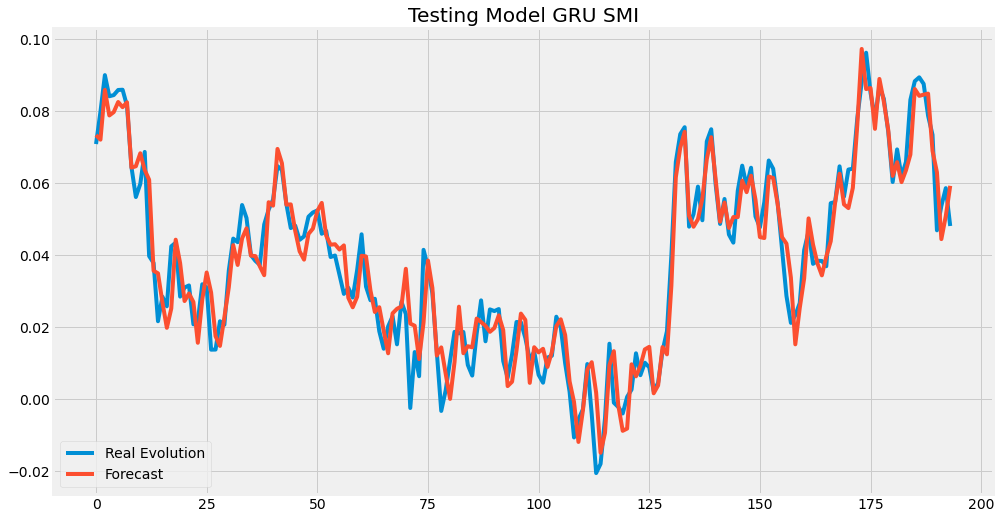

In [16]:
predicted_GRU_stock_price = modelGRU.predict(feature_test)
plot_results(predicted_GRU_stock_price,label_test, model = "GRU")

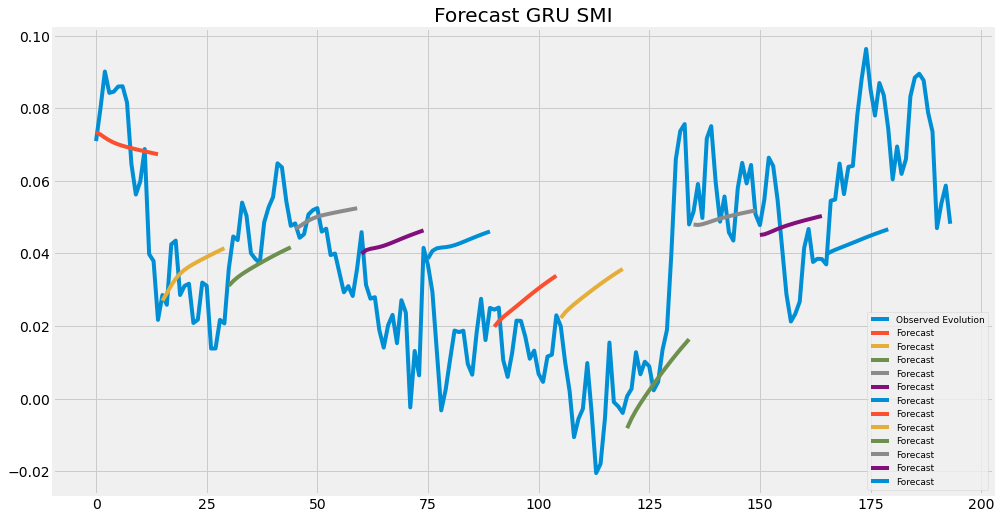

In [17]:
predictions_GRU = predict_sequences_multiple(modelGRU, feature_test, Enrol_window, 15)
plot_results_multiple(predictions_GRU, label_test, 15, model = "GRU")  

In [18]:
return_rmse(predicted_GRU_stock_price,label_test)

The root mean squared error is 0.007013806443807682.
